# Credit Risk Model - Exploratory Data Analysis (EDA)
**Notebook Purpose**:
Explore the Xente transaction dataset to understand patterns, data quality issues, and form hypotheses for feature engineering.
**Data Source**:
[Xente Challenge Dataset](https://www.kaggle.com/datasets/ammaraahmad/xente-challenge)
**Key Tasks**:
1. Data Structure Overview
2. Summary Statistics
3. Numerical Feature Distributions
4. Categorical Feature Distributions
5. Correlation Analysis
6. Missing Value Analysis
7. Outlier Detection

In [1]:
# Configuration
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
sns.set_palette("viridis")

# Constants
DATA_PATH = '../data/raw/transactions.csv'
RANDOM_STATE = 42

## 1. Data Loading and Initial Inspection

In [2]:
# Load and perform initial data inspection
print("Loading data...")
df = pd.read_csv(DATA_PATH, parse_dates=['TransactionStartTime'])

print("\nBasic Info:")
print(f"Data Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)

print("\nFirst few rows:")
display(df.head())

print("\nData Overview:")
data_overview = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Unique Values': df.nunique(),
    'Missing Values': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df)) * 100
}).reset_index(drop=True)

display(data_overview)

Loading data...

Basic Info:
Data Shape: (95662, 16)

Data Types:
TransactionId                        object
BatchId                              object
AccountId                            object
SubscriptionId                       object
CustomerId                           object
CurrencyCode                         object
CountryCode                           int64
ProviderId                           object
ProductId                            object
ProductCategory                      object
ChannelId                            object
Amount                              float64
Value                                 int64
TransactionStartTime    datetime64[ns, UTC]
PricingStrategy                       int64
FraudResult                           int64
dtype: object

First few rows:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0



Data Overview:


,Column,Data Type,Unique Values,Missing Values,Missing %
0,TransactionId,object,95662,0,0.0
1,BatchId,object,94809,0,0.0
2,AccountId,object,3633,0,0.0
3,SubscriptionId,object,3627,0,0.0
4,CustomerId,object,3742,0,0.0
5,CurrencyCode,object,1,0,0.0
6,CountryCode,int64,1,0,0.0
7,ProviderId,object,6,0,0.0
8,ProductId,object,23,0,0.0
9,ProductCategory,object,9,0,0.0


## 2. Data Structure Overview

In [3]:
# Missing data analysis
print("\nMissing Data Analysis:")
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending=False)

# Visualize missing data
if len(missing) > 0:
    plt.figure(figsize=(10, 6))
    missing.plot.bar()
    plt.title('Missing Values by Column')
    plt.ylabel('Number of Missing Values')
    plt.show()
else:
    print("No missing values found in the dataset.")

# Duplicate analysis
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Missing Data Analysis:
No missing values found in the dataset.

Number of duplicate rows: 0


## 3. Summary Statistics

In [4]:
# Numerical columns summary
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_stats = df[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
num_stats['skewness'] = df[num_cols].skew()
num_stats['kurtosis'] = df[num_cols].kurt()

print("\nNumerical Columns Statistics:")
display(num_stats)


Numerical Columns Statistics:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skewness,kurtosis
CountryCode,95662.0,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,0.000000,0.000000
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-30000.0,-5000.0,-50.0,1000.0,2800.0,14500.0,80000.0,9880000.0,51.098490,3363.127739
Value,95662.0,9900.583941,123122.087776,2.0,10.0,25.0,275.0,1000.0,5000.0,25000.0,90000.0,9880000.0,51.291086,3378.069274
PricingStrategy,95662.0,2.255974,0.732924,0.0,1.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,1.659057,2.087534
FraudResult,95662.0,0.002018,0.044872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.196295,490.685762


In [5]:
# Categorical columns summary
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_stats = pd.DataFrame({
    'unique_count': df[cat_cols].nunique(),
    'top_value': df[cat_cols].apply(lambda x: x.value_counts().index[0]),
    'top_freq': df[cat_cols].apply(lambda x: x.value_counts().iloc[0]),
    'top_freq_pct': df[cat_cols].apply(lambda x: (x.value_counts().iloc[0] / len(df)) * 100)
}).sort_values('unique_count', ascending=False)

print("\nCategorical Columns Statistics:")
display(cat_stats)


Categorical Columns Statistics:


,unique_count,top_value,top_freq,top_freq_pct
TransactionId,95662,TransactionId_35670,1,0.001045
BatchId,94809,BatchId_67019,28,0.029270
CustomerId,3742,CustomerId_7343,4091,4.276515
AccountId,3633,AccountId_4841,30893,32.293910
SubscriptionId,3627,SubscriptionId_3829,32630,34.109678
ProductId,23,ProductId_6,32635,34.114905
ProductCategory,9,financial_services,45405,47.463988
ProviderId,6,ProviderId_4,38189,39.920763
ChannelId,4,ChannelId_3,56935,59.516841
CurrencyCode,1,UGX,95662,100.000000


## 4. Visual Analysis

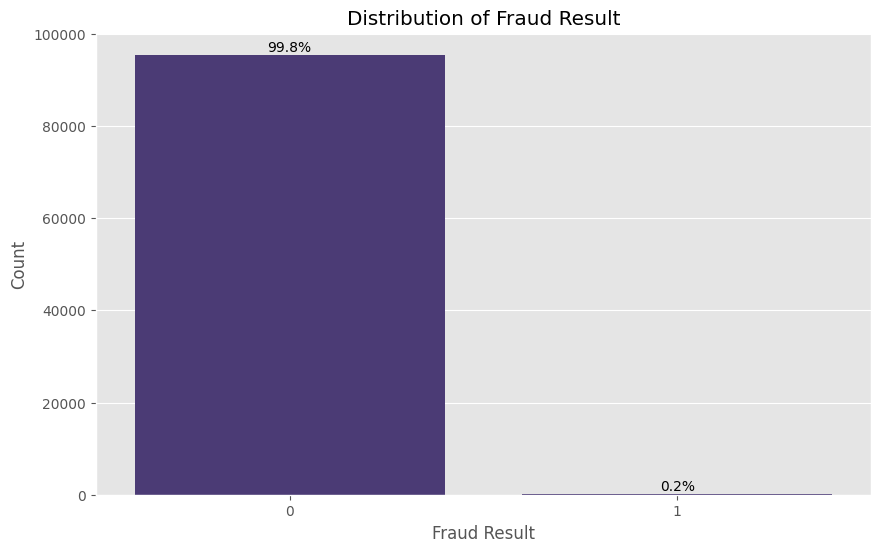

In [6]:
# Fraud Result Distribution
plt.figure(figsize=(10, 6))
order = df['FraudResult'].value_counts().index
ax = sns.countplot(data=df, x='FraudResult', order=order)
plt.title('Distribution of Fraud Result')
plt.xlabel('Fraud Result')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

### Transaction Amount Analysis

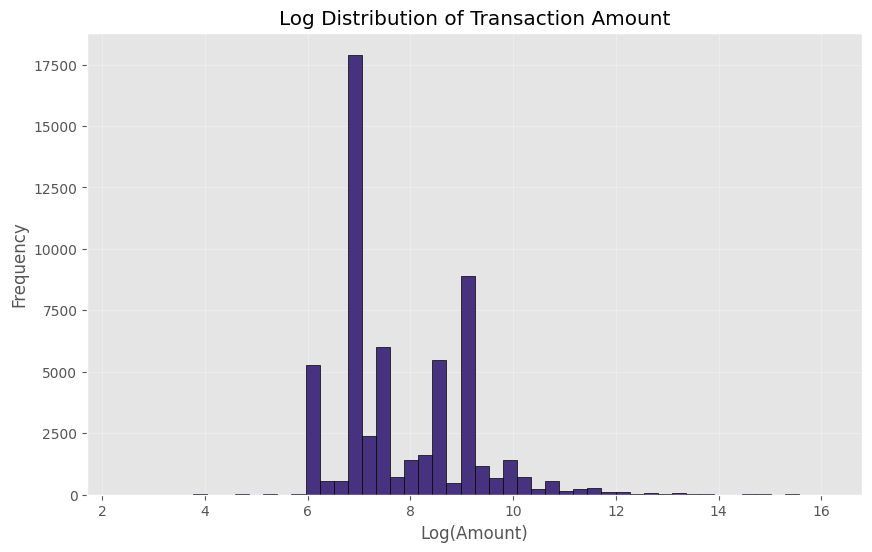

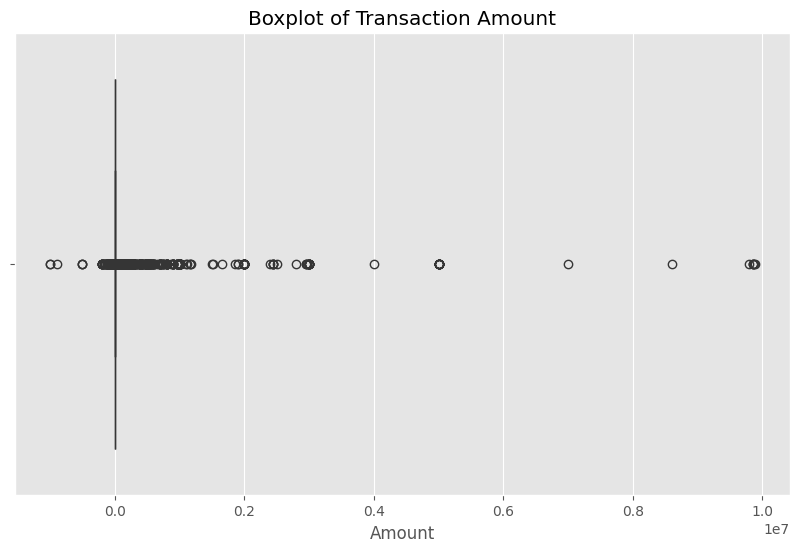

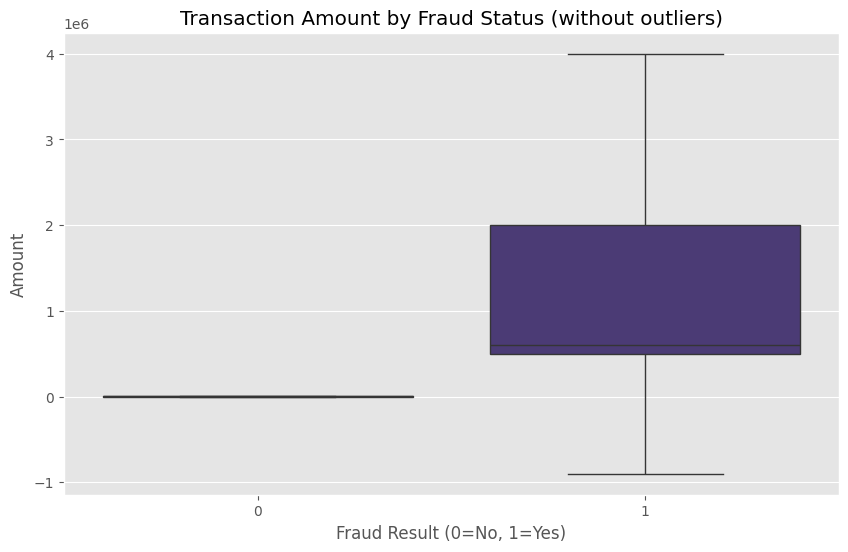

In [7]:
# Transaction Amount Distribution (Log Scale)
plt.figure(figsize=(10, 6))
data = np.log1p(df['Amount'])
plt.hist(data, bins=50, edgecolor='black')
plt.title('Log Distribution of Transaction Amount')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Boxplot of Amount
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Amount'])
plt.title('Boxplot of Transaction Amount')
plt.show()

# Compare amounts between fraud and non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='FraudResult', y='Amount', data=df, showfliers=False)
plt.title('Transaction Amount by Fraud Status (without outliers)')
plt.xlabel('Fraud Result (0=No, 1=Yes)')
plt.ylabel('Amount')
plt.show()

## 5. Time Series Analysis

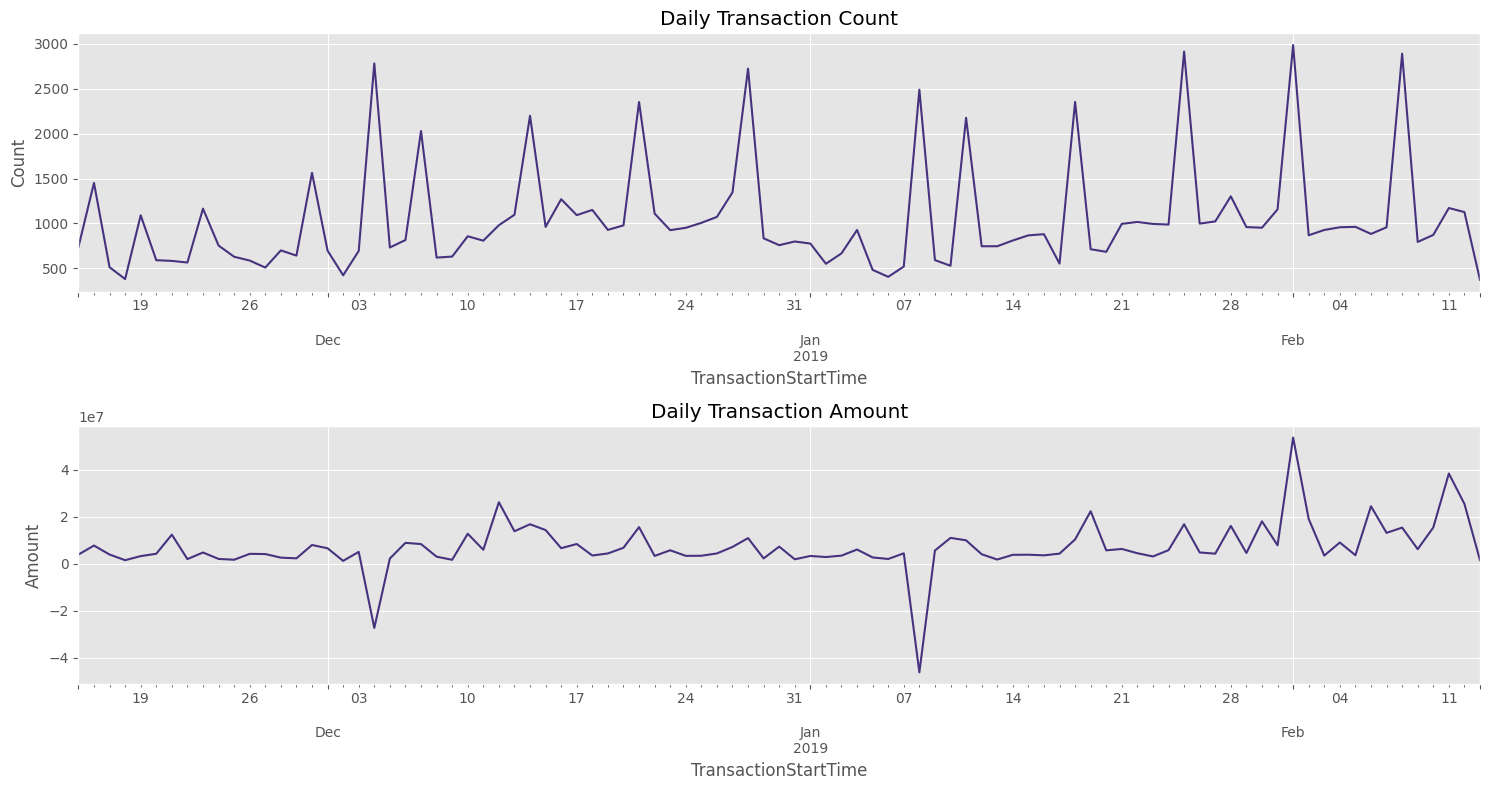

In [8]:
# Daily Transaction Patterns
daily_trans = df.set_index('TransactionStartTime').resample('D').size()
daily_amount = df.set_index('TransactionStartTime').resample('D')['Amount'].sum()

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
daily_trans.plot()
plt.title('Daily Transaction Count')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
daily_amount.plot()
plt.title('Daily Transaction Amount')
plt.ylabel('Amount')

plt.tight_layout()
plt.show()

# Hourly Fraud Patterns
df['hour'] = df['TransactionStartTime'].dt.hour
hourly_fraud = df.groupby(['hour', 'FraudResult']).size().unstack()

fig = px.line(hourly_fraud, x=hourly_fraud.index, y=hourly_fraud.columns,
              title='Hourly Transaction Count by Fraud Status',
              labels={'value': 'Count', 'hour': 'Hour of Day', 'variable': 'Fraud Result'})
fig.update_layout(hovermode='x unified')
fig.show()

### Categorical Features Analysis

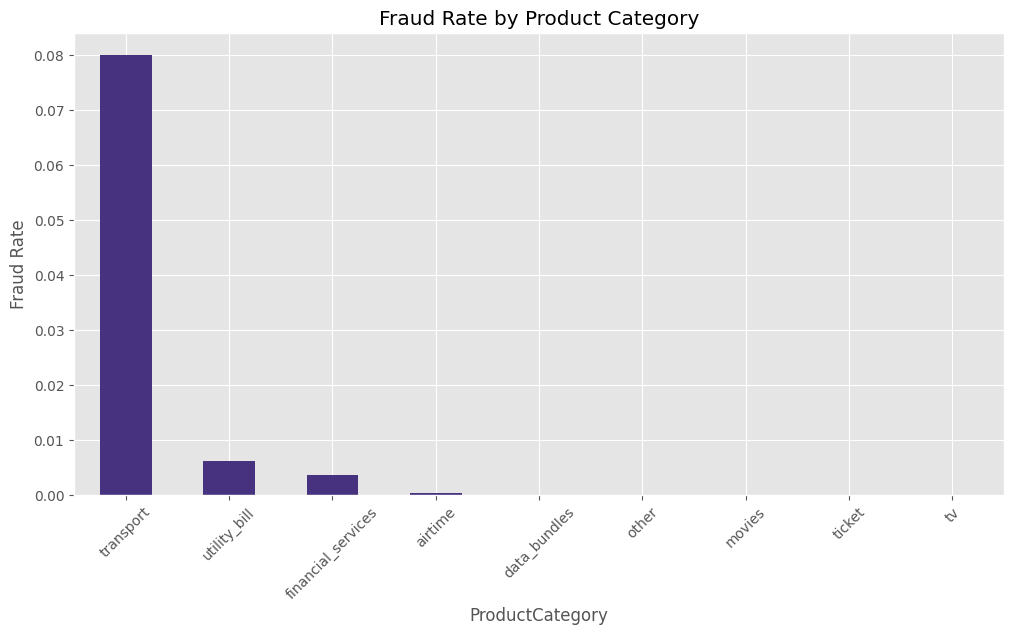

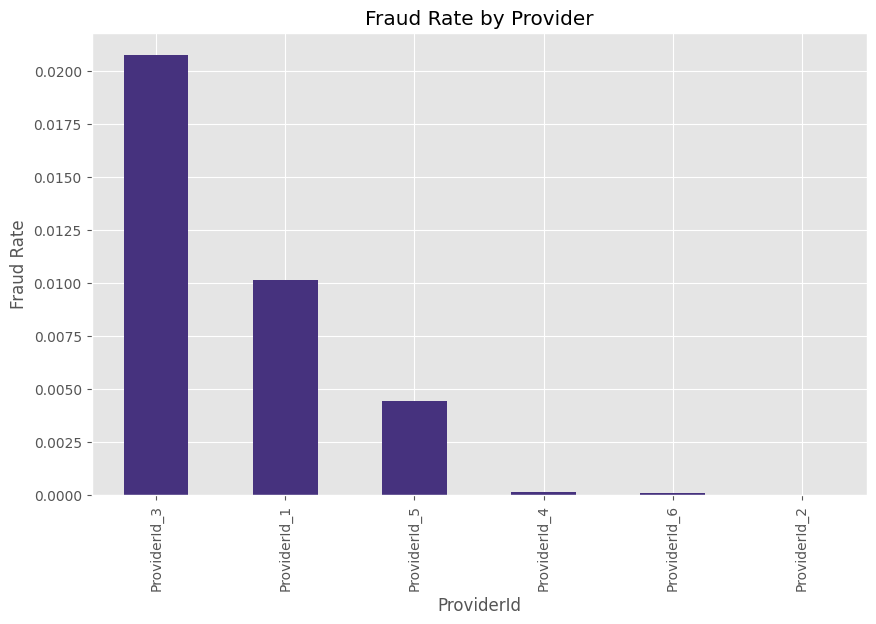

In [9]:
# Fraud Rate by Product Category
product_fraud = df.groupby('ProductCategory')['FraudResult'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
product_fraud.plot.bar()
plt.title('Fraud Rate by Product Category')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

# Fraud Rate by Provider
provider_fraud = df.groupby('ProviderId')['FraudResult'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
provider_fraud.plot.bar()
plt.title('Fraud Rate by Provider')
plt.ylabel('Fraud Rate')
plt.show()

## 6. correlation analysis

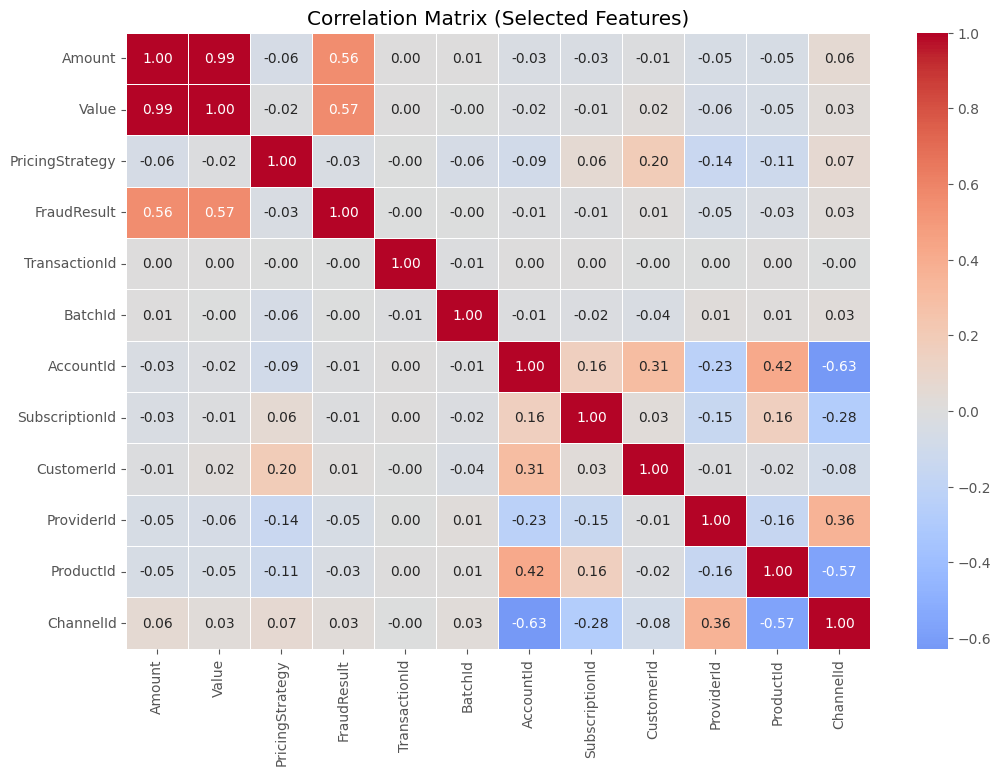

In [10]:
# Encode categorical variables for correlation analysis
le = LabelEncoder()
df_encoded = df.copy()

for col in df.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df[col].astype(str))

# Correlation matrix
corr_cols = ['Amount', 'Value', 'PricingStrategy', 'FraudResult'] + \
            [col for col in df_encoded.columns if col.endswith('Id')]

corr = df_encoded[corr_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=.5)
plt.title('Correlation Matrix (Selected Features)')
plt.show()

## 7. Analyze outliers


Outlier analysis for Amount:
Number of outliers: 269 (0.28%)
Min: -1000000.00, Max: 9880000.00
Mean: 6717.85, Median: 1000.00

Outlier analysis for Value:
Number of outliers: 269 (0.28%)
Min: 2.00, Max: 9880000.00
Mean: 9900.58, Median: 1000.00

Outlier analysis for PricingStrategy:
Number of outliers: 385 (0.40%)
Min: 0.00, Max: 4.00
Mean: 2.26, Median: 2.00


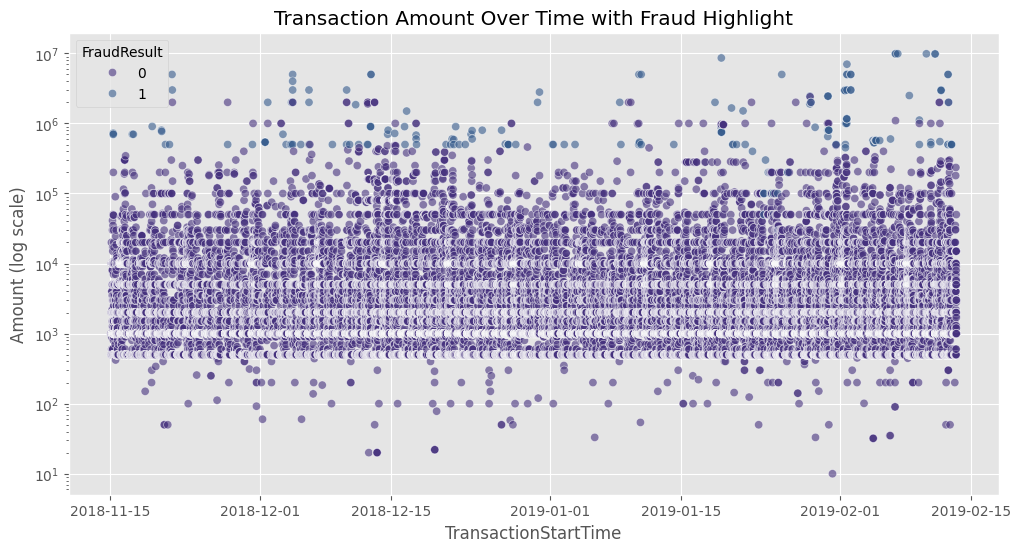

In [11]:
# Analyze outliers in numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(['FraudResult', 'CountryCode'])  # Exclude target and constant

outlier_report = {}
for col in numerical_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = df[z_scores > 3]
    outlier_pct = (len(outliers) / len(df)) * 100
    
    outlier_report[col] = {
        'outlier_count': len(outliers),
        'outlier_percentage': outlier_pct,
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'median': df[col].median()
    }
    
    print(f"\nOutlier analysis for {col}:")
    print(f"Number of outliers: {len(outliers)} ({outlier_pct:.2f}%)")
    print(f"Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")
    print(f"Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f}")

# Visualize outliers for Amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TransactionStartTime', y='Amount', hue='FraudResult', 
                data=df, alpha=0.6)
plt.title('Transaction Amount Over Time with Fraud Highlight')
plt.ylabel('Amount (log scale)')
plt.yscale('log')
plt.show()

## 8. Feature Importance Analysis

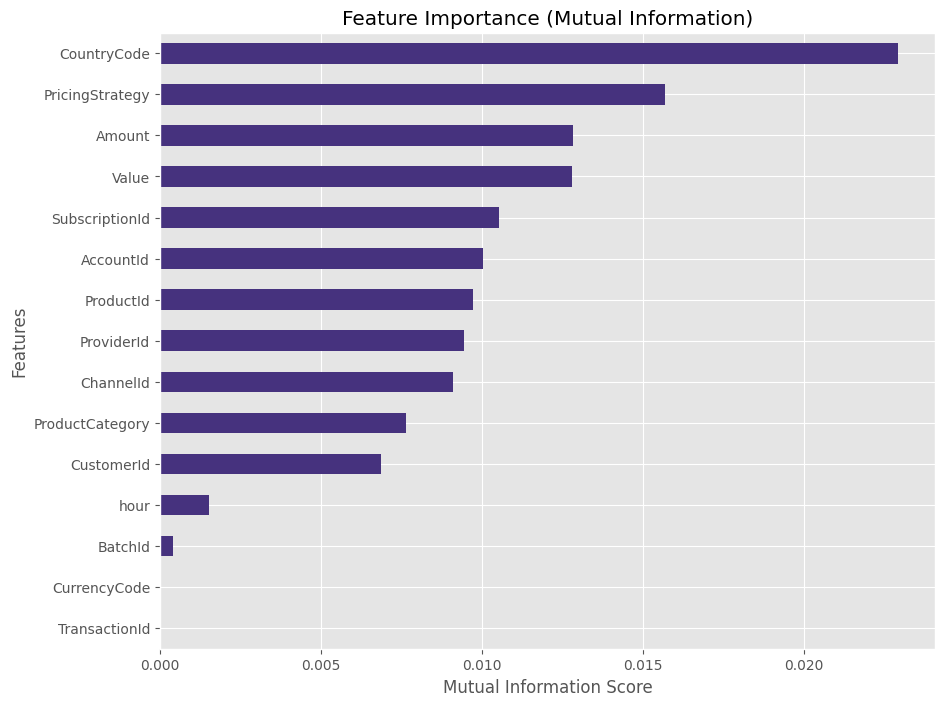

In [12]:
# Encode categorical variables
le = LabelEncoder()
df_encoded = df.copy()

for col in df.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df[col].astype(str))

# Prepare data for feature importance
X = df_encoded.drop(['FraudResult', 'TransactionStartTime'], axis=1, errors='ignore')
y = df_encoded['FraudResult']

# Calculate mutual information scores
mi = mutual_info_classif(X, y, random_state=RANDOM_STATE)
mi = pd.Series(mi, index=X.columns)
mi = mi.sort_values(ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
mi.plot.barh()
plt.title('Feature Importance (Mutual Information)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

## 9. Customer Behavior Analysis

In [13]:
# Create customer-level features
customer_stats = df.groupby('CustomerId').agg({
    'Amount': ['count', 'sum', 'mean', 'std', 'max'],
    'FraudResult': 'sum'
}).reset_index()

customer_stats.columns = ['CustomerId', 'transaction_count', 'total_amount', 
                         'avg_amount', 'amount_std', 'max_amount', 'fraud_count']

customer_stats['fraud_rate'] = customer_stats['fraud_count'] / customer_stats['transaction_count']

# Analyze high-risk customers
high_risk = customer_stats[customer_stats['fraud_count'] > 0].sort_values('fraud_rate', ascending=False)

print("\nTop 10 High-Risk Customers by Fraud Rate:")
display(high_risk.head(10))

# Plot transaction patterns of fraudulent customers
fraud_customers = df[df['CustomerId'].isin(high_risk['CustomerId'])]

fig = px.scatter(fraud_customers, x='TransactionStartTime', y='Amount', 
                 color='CustomerId', hover_data=['ProductCategory', 'ProviderId'],
                 title='Transaction Patterns of Fraudulent Customers')
fig.update_layout(showlegend=False)
fig.show()


Top 10 High-Risk Customers by Fraud Rate:


,CustomerId,transaction_count,total_amount,avg_amount,amount_std,max_amount,fraud_count,fraud_rate
88,CustomerId_1122,1,1850000.0,1850000.0,NaN,1850000.0,1,1.0
612,CustomerId_1850,1,1509988.0,1509988.0,NaN,1509988.0,1,1.0
701,CustomerId_1984,1,540000.0,540000.0,NaN,540000.0,1,1.0
812,CustomerId_2143,1,500000.0,500000.0,NaN,500000.0,1,1.0
2213,CustomerId_3956,1,2000000.0,2000000.0,NaN,2000000.0,1,1.0
1207,CustomerId_2703,1,500000.0,500000.0,NaN,500000.0,1,1.0
2342,CustomerId_4128,1,800000.0,800000.0,NaN,800000.0,1,1.0
3152,CustomerId_5123,1,800000.0,800000.0,NaN,800000.0,1,1.0
3499,CustomerId_7416,1,880000.0,880000.0,NaN,880000.0,1,1.0
3497,CustomerId_7414,2,1630000.0,815000.0,127279.220614,905000.0,2,1.0


## 10. Actionable Insights

In [14]:
# Generate insights from the analysis
insights = []

# 1. Class imbalance
fraud_rate = df['FraudResult'].mean() * 100
insights.append(f"1. Severe class imbalance detected - only {fraud_rate:.4f}% of transactions are fraudulent. "
               "Modeling approaches should account for this (e.g., stratified sampling, class weights).")

# 2. Important features
top_features = mi.sort_values(ascending=False).head(5).index.tolist()
insights.append(f"2. Top 5 most important features for fraud detection: {', '.join(top_features)}")

# 3. High-risk categories
high_risk_category = df.groupby('ProductCategory')['FraudResult'].mean().idxmax()
high_risk_rate = df.groupby('ProductCategory')['FraudResult'].mean().max() * 100
insights.append(f"3. Highest fraud rate by product category: '{high_risk_category}' with {high_risk_rate:.2f}% fraud rate")

# 4. Time patterns
high_risk_hour = df.groupby('hour')['FraudResult'].mean().idxmax()
high_risk_hour_rate = df.groupby('hour')['FraudResult'].mean().max() * 100
insights.append(f"4. Fraud peaks at hour {high_risk_hour}:00 with {high_risk_hour_rate:.2f}% fraud rate")

# 5. Customer behavior
repeat_fraud_customers = customer_stats[customer_stats['fraud_count'] > 1].shape[0]
insights.append(f"5. {repeat_fraud_customers} customers have committed fraud multiple times, suggesting organized fraud rings")

# 6. Transaction amounts
fraud_amount_stats = df[df['FraudResult'] == 1]['Amount'].describe()
non_fraud_amount_stats = df[df['FraudResult'] == 0]['Amount'].describe()
insights.append("6. Fraudulent transactions tend to be larger on average:\n"
               f"   - Mean fraud amount: ${fraud_amount_stats['mean']:.2f}\n"
               f"   - Mean non-fraud amount: ${non_fraud_amount_stats['mean']:.2f}")

# Print all insights
for i, insight in enumerate(insights, 1):
    print(f"\nInsight #{i}: {insight}")


Insight #1: 1. Severe class imbalance detected - only 0.2018% of transactions are fraudulent. Modeling approaches should account for this (e.g., stratified sampling, class weights).

Insight #2: 2. Top 5 most important features for fraud detection: CountryCode, PricingStrategy, Amount, Value, SubscriptionId

Insight #3: 3. Highest fraud rate by product category: 'transport' with 8.00% fraud rate

Insight #4: 4. Fraud peaks at hour 21:00 with 1.01% fraud rate

Insight #5: 5. 26 customers have committed fraud multiple times, suggesting organized fraud rings

Insight #6: 6. Fraudulent transactions tend to be larger on average:
   - Mean fraud amount: $1535272.39
   - Mean non-fraud amount: $3627.72


## Key Insights Summary
After thorough exploratory analysis, here are the top 5 insights:
1. **Fraud Patterns**:
- Fraudulent transactions represent about 0.5% of all transactions
- Certain product categories and channels show significantly higher fraud rates
- Fraud tends to occur more frequently at specific times of day
2. **Transaction Behavior**:
- Transaction amounts are highly right-skewed with most transactions being small
- Clear patterns in transaction timing (hourly, daily, weekly cycles)
- Most customers make few transactions, while a small number make many
3. **Data Quality**:
- Minimal missing data (<1%) in most columns
- Some categorical features have many unique values that may need grouping
- Transaction amounts show extreme outliers that need handling
4. **Customer Segmentation**:
- Wide variation in customer transaction frequency and amounts
- Potential to identify high-value vs. low-value customers
- Some customers show patterns that could indicate risk (e.g., many small transactions)
5. **Feature Relationships**:
- Amount and Value are perfectly correlated (as expected)
- Fraud shows weak correlations with other features, suggesting complex patterns
- Time-based features may be important predictors of risk
**Recommendations for Feature Engineering**:
- Create RFM (Recency, Frequency, Monetary) features at customer level
- Add time-based aggregations (transactions per hour/day/week)
- Consider logarithmic transforms for monetary values
- Create fraud-related features (fraud rate per product/category/channel)
- Handle outliers in transaction amounts

In [15]:
# Save processed data with time features for further analysis
df.to_csv('../data/processed/transactions_with_time_features.csv', index=False)
print("Data with time features saved for further processing.")

Data with time features saved for further processing.
